In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import json

## Load dataset

In [2]:
df = pd.read_csv("data/data_clean.csv")
df.shape

(232687, 40)

In [3]:
df.head()

,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,Distance(mi),Street,City,County,State,...,Sunrise_Sunset,Is_Highway,Duration(min),Date,Hour,Day_of_Week,Is_Weekend,Month,Year,Is_Night
0,3,2016-02-11 05:32:29,2016-02-11 06:02:29,41.422199,-81.843018,0.01,Grayton Rd,Cleveland,Cuyahoga,OH,...,Night,False,30.000000,2016-02-11,5,4,False,2,2016,True
1,3,2016-02-11 06:29:00,2016-02-11 21:00:00,41.420818,-81.694008,0.01,I-480 E,Cleveland,Cuyahoga,OH,...,Night,True,871.000000,2016-02-11,6,4,False,2,2016,True
2,3,2016-02-11 07:29:06,2016-02-11 08:18:10,41.355396,-81.819267,0.01,I-71 S,Cleveland,Cuyahoga,OH,...,Day,True,49.066667,2016-02-11,7,4,False,2,2016,False
3,2,2016-02-15 07:37:49,2016-02-15 08:07:49,41.410461,-81.725853,0.00,Westlake Ave,Cleveland,Cuyahoga,OH,...,Day,False,30.000000,2016-02-15,7,1,False,2,2016,False
4,2,2016-02-18 06:27:59,2016-02-18 06:57:59,41.414131,-81.632141,0.01,Granger Rd,Cleveland,Cuyahoga,OH,...,Night,False,30.000000,2016-02-18,6,4,False,2,2016,True


## Exploratory data analysis

#### Summary of Insights
1. Dominance of Severity Level 2: The dataset is heavily skewed towards severity level 2, comprising a significant majority of incidents. This imbalance may influence model predictions and accuracy, requiring careful handling of the dataset to avoid bias.
2. Impact of Weather Conditions:
    * *Dry Weather:* While the majority of accidents occur under dry conditions, they tend to result in moderate severity levels (2 and 3). This suggests that even in seemingly safe conditions, accidents can still be severe.
    * *Snowy Conditions:* Snow significantly increases the likelihood of severe accidents, indicating that adverse weather conditions should be prioritized in safety measures.
    * *Wet Conditions:* Though wet conditions account for fewer accidents, they still pose a substantial risk for higher severity levels.
3. Temporal Factors:
    * *Peak Hours:* Accidents peak during morning and evening rush hours, highlighting the importance of traffic density in predicting accident severity.
    * *Day and Month Patterns:* Weekday and winter month trends indicate that specific temporal factors contribute to increased accident rates and severities.
4. Numerical Variables:
    * *Distance and Duration:* Most accidents affect short road distances, suggesting minor incidents, while longer durations may correlate with more severe accidents, particularly when cleanup is prolonged.
    * *Weather Influences:* Variations in atmospheric pressure and wind speed correlate with severity, emphasizing the need for weather-related predictors in the model.
5. Boolean and Categorical Variables:
    * Features like highway presence, junctions, and traffic signals play significant roles in predicting severity. Absence of safety features often correlates with higher severity.

### 1. Univariate analysis

#### 1.1. Dependent variable (`Severity`)
Accident of severity level 2 significantly dominate the dataset. About 66% of all recorded accidents had a severity level 2. Meanwhile accidents of serverity level 1 are the rarest, followed by level 4.

In [4]:
df["Severity"].value_counts() / len(df)

2    0.660338
3    0.315458
4    0.018441
1    0.005763
Name: Severity, dtype: float64

#### 1.2. Numerical variables
* *Distance Affected:* A large number of accidents affect very short road distances (median is 0.83 miles), suggesting many are minor or localized events.
* *Duration:* The median accident duration is around 58 minutes, with a maximum of 24 hours (manual cut-off), showing that most accidents are cleared quickly, though some are severe enough to require extensive time for cleanup.
* *Weather:* Accidents happen across extreme weather conditions, with temperatures ranging from -29°F to 101°F and various humidity and wind conditions, indicating diverse environmental factors at play.
* *Peak Accident Hours:* Accidents peak between 7 AM and 8 AM, with another surge around 4 PM to 5 PM. This reflects typical commuting times, indicating that a large proportion of accidents occur during rush hours when traffic density is highest.
* *Days of the Week:* The majority of accidents happen from Monday to Friday, with Friday having the highest accident count. Fewer accidents are recorded over the weekend, especially on Sunday, suggesting a direct correlation with weekday commuting and work-related travel.
* *Months:* Accident frequencies are highest in the winter months of December, January, and February, likely due to hazardous weather conditions such as snow and ice. Accident counts drop slightly in the summer but remain significant year-round.

In [5]:
numerical_vars = df.select_dtypes(include=['number']).columns.tolist()

Considering our goals, certain variables may be irrelevant. For instance, since we are building a predictive model of the city of Montreal using US data, any location-related variable (e.g. coordinates) would be ignored. In addition, the Year may also be ignored as we have data covering a 7-years period.

In [6]:
for col in ["Start_Lat", "Start_Lng", "Year"]:
    if col in numerical_vars:
        numerical_vars.remove(col)

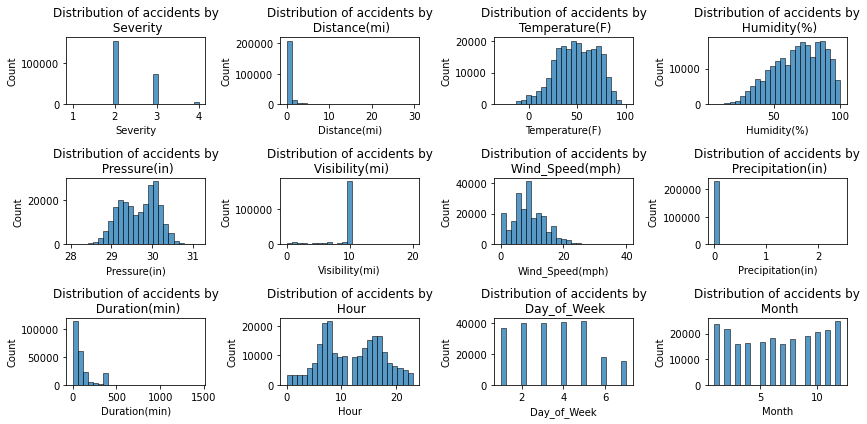

In [7]:
# Set up the subplots
fig, axes = plt.subplots(3, 4, figsize=(12, 6))
axes = axes.flatten()
# Create a box plot for each variable
for i,var in enumerate(numerical_vars):
    sns.histplot(data=df, x=var, ax=axes[i], bins=25)
    axes[i].set_title(f'Distribution of accidents by\n {var}', fontsize=12)
    axes[i].set_ylabel('Count')
    axes[i].set_xlabel(var)
plt.tight_layout()
plt.show()

#### 1.3. Boolean variables
* *Highway Accidents:* A substantial number of accidents occur on highways, emphasizing the increased risk associated with higher-speed roads.
* *Crossings and Traffic Signals:* Accidents near crossings and traffic signals are frequent, highlighting high-risk areas for both vehicles and pedestrians.
* *Night and Weekend Accidents:* 32% of accidents happen during the night, indicating riskier times for accidents due to low visibility.
* *Junctions and Stations:* Accidents are fairly common near junctions and stations, which are high-traffic zones where vehicles and pedestrians converge.

Overall, most accidents occurred when the boolean values are False (e.g., no amenity, no bump, no railway, etc.) suggests that many accidents happen in areas without these specific traffic features or control measures. This could imply that:
1. Traffic features like signals, junctions, bumps, and crossings may help reduce accidents by regulating traffic or alerting drivers.
2. The lack of physical traffic calming features may not reduce driver speeds or behavior, potentially increasing accident risks, especially in less regulated or monitored areas.
3. Since a significant proportion of accidents happen on highways (where features like crossings, bumps, and junctions are less common), it makes sense that the boolean values for these are often false in those scenarios.

In [8]:
boolean_vars = df.select_dtypes(include=['bool']).columns.tolist()

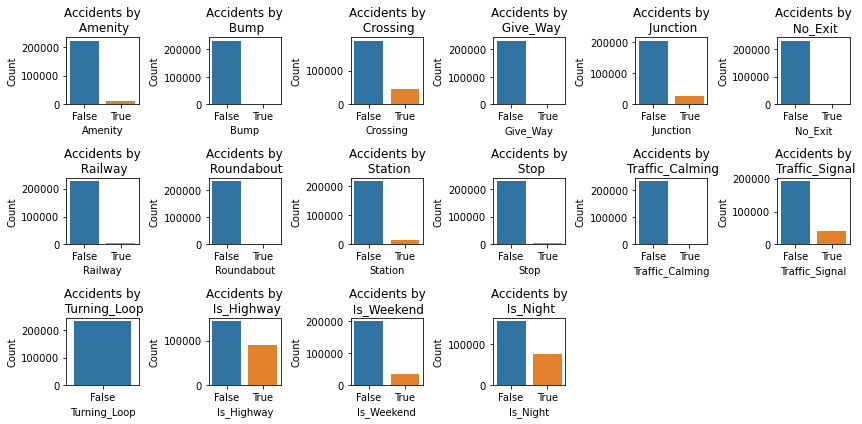

In [9]:
# Set up the subplots
fig, axes = plt.subplots(3, 6, figsize=(12, 6))
axes = axes.flatten()
# Create a box plot for each variable
for i,var in enumerate(boolean_vars):
    sns.countplot(data=df, x=var, ax=axes[i])
    axes[i].set_title(f'Accidents by\n {var}', fontsize=12)
    axes[i].set_ylabel('Count')
    axes[i].set_xlabel(var)
# Hide unused subplots
for ax in axes[len(boolean_vars):]:
    ax.remove()
plt.tight_layout()
plt.show()

Some of the boolean variables are very imbalanced, which might affect how informative the variable is for predicting the target.

In [10]:
high_imbalance_vars = []
for var in boolean_vars:
    proportions = df[var].value_counts() / len(df)
    if len(proportions.index) != 2 or np.abs(proportions[False] - proportions[True]) > 0.7:
        high_imbalance_vars.append(var)

In [11]:
high_imbalance_vars

['Amenity',
 'Bump',
 'Give_Way',
 'Junction',
 'No_Exit',
 'Railway',
 'Roundabout',
 'Station',
 'Stop',
 'Traffic_Calming',
 'Turning_Loop',
 'Is_Weekend']

We may discard these variables except for Is_Weekend which may hold some useful information.

In [12]:
high_imbalance_vars.remove("Is_Weekend")

In [13]:
for c in high_imbalance_vars:
    if c in boolean_vars:
        boolean_vars.remove(c)

#### 1.4. Categorical variables
The majority of traffic accidents (82%) occur under dry weather conditions, but significant risks remain during wet (10%) and snowy (7.4%) conditions, highlighting the need for targeted safety measures during adverse weather while also addressing contributing factors in dry conditions.

In [14]:
categorical_vars = df.select_dtypes(include=['object','category']).columns.tolist()

In [15]:
df["Weather_Condition"].unique()

array(['Winter Weather', 'Cloudy', 'Clear', 'Rain', 'Reduced Visibility',
       'Extreme/Stormy Weather', 'Other/Unknown'], dtype=object)

Some columns are now redundant since we used them to create other variables. For example, Start_Time and End_Time as no longer needed as we have plenty of more relevant temporal variables. In addition, columns such as County, City and Street have too many unique values to be usuable as they are. Furthermore, given that we are building a model using data from US cities similar to Montreal, the State variable wouldn't be needed as a feature for our models. We are thus left with Weather_Condition.

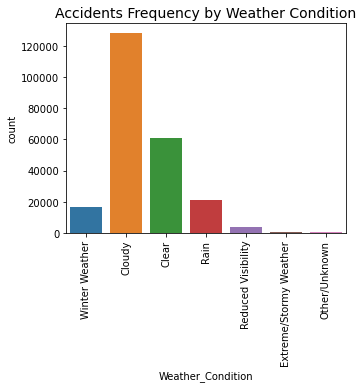

In [17]:
# Count the occurrences of each category
category_counts = df['Weather_Condition'].value_counts()
# Plot barplot
plt.figure(figsize=(5, 5.5))
sns.countplot(data=df, x="Weather_Condition")
plt.title('Accidents Frequency by Weather Condition', fontsize=14)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### 2. Correlation analysis

In [18]:
import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [19]:
def test_multicollinearity(df, variables):
    X = df[variables]
    vif_data = pd.DataFrame()  # Variance Inflation Factor (VIF)
    vif_data["Variable"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
    print(vif_data)

In [20]:
def ordinal_lr(df, ordinal_cols, target, maxiter=1000):
    X = df[ordinal_cols]
    y = df[target]
    # Fit an ordinal logistic regression model
    model = OrderedModel(y, X, distr='logit')
    result = model.fit(maxiter=maxiter)
    # Summary of the model
    print(result.summary())

#### 2.1. Numerical variables
* *Weather Influence:* Higher atmospheric pressure and wind speed correlate with increased incident severity, while better visibility is associated with lower severity, highlighting the impact of weather conditions.
* *Distance Effect:* Greater distances relate to decreased severity, suggesting that incidents occurring over longer distances may be less severe.
* *Temporal Variations:* Severity varies by time of day, day of the week, and month, indicating that certain periods carry higher risks for severe incidents.

In [21]:
numerical_vars.remove("Severity")

In [22]:
test_multicollinearity(df, numerical_vars)

             Variable        VIF
0        Distance(mi)   1.192036
1      Temperature(F)   7.342988
2         Humidity(%)  21.198413
3        Pressure(in)  79.498532
4      Visibility(mi)  17.259509
5     Wind_Speed(mph)   3.930968
6   Precipitation(in)   1.125525
7       Duration(min)   1.707068
8                Hour   6.088597
9         Day_of_Week   4.965631
10              Month   4.566228


Certain variables such as Humidity, Pressure, and Visibility have high collinearity. There presence may affect the model's performances; on the other hand, we could create a new feature from them. In additon, there is a moderate negative correlation between Pressure and Precipitation. Given that Pressure has high collinearity, we may drop it.

In [23]:
for col in ["Pressure(in)", "Visibility(mi)"]:
    if col in numerical_vars:
        numerical_vars.remove(col)

In [24]:
test_multicollinearity(df, numerical_vars)

            Variable       VIF
0       Distance(mi)  1.185831
1     Temperature(F)  5.592941
2        Humidity(%)  6.852734
3    Wind_Speed(mph)  3.433243
4  Precipitation(in)  1.051317
5      Duration(min)  1.689640
6               Hour  5.064532
7        Day_of_Week  4.577233
8              Month  4.457687


In [25]:
ordinal_lr(df, numerical_vars, "Severity", maxiter=5000)

Optimization terminated successfully.
         Current function value: 0.728042
         Iterations: 3030
         Function evaluations: 4163
                             OrderedModel Results                             
Dep. Variable:               Severity   Log-Likelihood:            -1.6941e+05
Model:                   OrderedModel   AIC:                         3.388e+05
Method:            Maximum Likelihood   BIC:                         3.390e+05
Date:                Mon, 30 Sep 2024                                         
Time:                        21:49:54                                         
No. Observations:              232687                                         
Df Residuals:                  232675                                         
Df Model:                           9                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------

The p-value for Humidity is very high (0.78), it is therefore not a significant predictor. In addition, we can use a boolean variable to signify if we are on a weekend or not, thus we may discard Day_of_Week.

In [26]:
for col in ["Humidity(%)", "Day_of_Week"]:
    if col in numerical_vars:
        numerical_vars.remove(col)

#### 2.2. Boolean variables
* Most variables are statistically significant in predicting accident severity, except Roundabout and Give_Way.
* *Bump, No_Exit, Railway, Is_Highway, Is_Weekend, Is_Night:* These factors is associated with a higher likelihood of more severe accidents.
* *Amenity, Crossing, Junction, Traffic Signal, Stop:* These factors is associated with a lower likelihood of more severe accidents.

In [27]:
test_multicollinearity(df, boolean_vars)

         Variable       VIF
0        Crossing  0.000040
1  Traffic_Signal  0.000044
2      Is_Highway  0.000013
3      Is_Weekend  0.000034
4        Is_Night  0.000017


In [28]:
ordinal_lr(df, boolean_vars, "Severity", maxiter=8000)

Optimization terminated successfully.
         Current function value: 0.724402
         Iterations: 1173
         Function evaluations: 1708
                             OrderedModel Results                             
Dep. Variable:               Severity   Log-Likelihood:            -1.6856e+05
Model:                   OrderedModel   AIC:                         3.371e+05
Method:            Maximum Likelihood   BIC:                         3.372e+05
Date:                Mon, 30 Sep 2024                                         
Time:                        21:50:41                                         
No. Observations:              232687                                         
Df Residuals:                  232679                                         
Df Model:                           5                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------

#### 2.3. Categorical variables
* *Dry Weather:* Accidents occurring under dry conditions predominantly result in severity levels 2 (medium) and 3 (high). This indicates that while dry weather is common, it often leads to moderate severity outcomes.
* *Snowy Conditions:* Snowy weather is associated with a significant increase in severity levels 3 (high) and 4 (very high). This suggests that snow greatly impacts the likelihood of severe accidents.
* *Other and Wet Weather:* While accidents under 'Other' and 'Wet Weather' can reach severity levels 3 (high) and 4 (very high), their overall contribution to accident severity is relatively lower. This implies that these conditions are less critical factors in determining accident severity compared to dry and snowy weather.
* *Low Pseudo R-squared:* The model's ability to explain the variability in Severity is low, indicating that other factors not included in the model may also play a significant role

In [29]:
categorical_vars = ["Weather_Condition"]

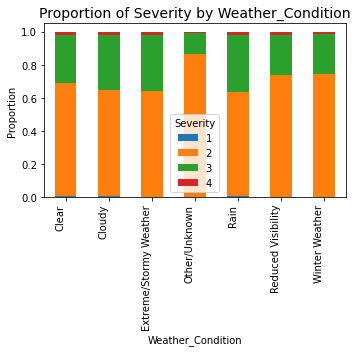

In [30]:
for col in categorical_vars:
    # Calculate normalized counts (proportions) and pivot the data
    df_pivot = (df.groupby([col, 'Severity']).size()
                 .groupby(level=0, group_keys=False)
                 .apply(lambda x: x / x.sum())
                 .unstack()
                 .fillna(0))
    # Plot a stacked barplot
    fig, ax = plt.subplots(figsize=(5, 5))
    df_pivot.plot(kind='bar', stacked=True, ax=ax, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
    # Set labels and title
    ax.set_title(f'Proportion of Severity by {col}', fontsize=14)
    ax.set_xlabel(col)
    ax.set_ylabel('Proportion')
    # Show legend and rotate x-axis labels if needed
    ax.legend(title='Severity')
    plt.xticks(rotation=90, ha='right')
    plt.tight_layout()
    # Show plot
    plt.show()


### Features selected

In [31]:
features = numerical_vars + boolean_vars + categorical_vars
len(features)

13

In [32]:
df[features].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232687 entries, 0 to 232686
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Distance(mi)       232687 non-null  float64
 1   Temperature(F)     232687 non-null  float64
 2   Wind_Speed(mph)    232687 non-null  float64
 3   Precipitation(in)  232687 non-null  float64
 4   Duration(min)      232687 non-null  float64
 5   Hour               232687 non-null  int64  
 6   Month              232687 non-null  int64  
 7   Crossing           232687 non-null  bool   
 8   Traffic_Signal     232687 non-null  bool   
 9   Is_Highway         232687 non-null  bool   
 10  Is_Weekend         232687 non-null  bool   
 11  Is_Night           232687 non-null  bool   
 12  Weather_Condition  232687 non-null  object 
dtypes: bool(5), float64(5), int64(2), object(1)
memory usage: 15.3+ MB
